 # Importing the required Libaries and other Functions

In [1]:
# PySpark API:
#http://spark.apache.org/docs/latest/api/python/index.html

import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName2")
sc = SparkContext(conf=conf)

# initialise sc
#from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.types import *
#sc= SparkContext()
sqlContext = SQLContext(sc)


# get python and spark versions
import platform
print(platform.python_version())
print(sc.version)

# import python sql libraries and other functions 
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# import python library for plotting data
import matplotlib.pyplot as plt
import gmplot

#import pandas and numpy
import pandas as pd
import numpy as np

3.6.8
2.4.3


In [2]:
# Importing Additional Libraries
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when

spark = SparkSession.builder.appName("Yorkshire Police").config("spark.jars.packages","graphframes:graphframes:0.6.0-spark2.3-s_2.11").enableHiveSupport().getOrCreate()

sqlContext = SQLContext(spark)

# Load the West Yorkshire Police dataset into rdd as one file

In [3]:
# All the files downloaded from police site are loaded as a single file
#Open source police data available from https://data.police.uk/data/

Yorkshire_data = sc.wholeTextFiles("hdfs:///user/imat5322_208953/*west-yorkshire-street.csv")\
.map(lambda x: x[1]).take(3)

In [4]:
type(Yorkshire_data)

list

In [5]:
# Covert the list data to an RDD
RDD_Yorkshire = sc.parallelize(Yorkshire_data)

#Get the count of the files
RDD_Yorkshire.count()

3

## Flatten the data out to have access per line and then per word

In [6]:
# flatten the data out to handle data per line instead of per file
RDD1_Yorkshire =RDD_Yorkshire.flatMap(lambda x: x.split('\n'))

In [7]:
#shows the number of lines
RDD1_Yorkshire.count()

82584

In [8]:
RDD1_Yorkshire.take(2)

['Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context\r',
 '44e2ee4bdc8aab99b8d4fa1a0b6b4e260de4334e7dd381e6cae7e2ce31e0caa1,2019-02,West Yorkshire Police,West Yorkshire Police,-1.882481,53.924936,On or near Moorside Lane,E01010646,Bradford 001A,Other theft,Investigation complete; no suspect identified,\r']

In [9]:
#split the line into words
RDD2_Yorkshire = RDD1_Yorkshire.map(lambda x: x.split(","))

In [10]:
RDD2_Yorkshire.take(2)

[['Crime ID',
  'Month',
  'Reported by',
  'Falls within',
  'Longitude',
  'Latitude',
  'Location',
  'LSOA code',
  'LSOA name',
  'Crime type',
  'Last outcome category',
  'Context\r'],
 ['44e2ee4bdc8aab99b8d4fa1a0b6b4e260de4334e7dd381e6cae7e2ce31e0caa1',
  '2019-02',
  'West Yorkshire Police',
  'West Yorkshire Police',
  '-1.882481',
  '53.924936',
  'On or near Moorside Lane',
  'E01010646',
  'Bradford 001A',
  'Other theft',
  'Investigation complete; no suspect identified',
  '\r']]

## Data Cleansing and Preprocessing

### Define Header

In [11]:
#define Header from the RDD
#Note: the RDD must be exactly the same as the other

Header = RDD2_Yorkshire.first()

In [12]:
#count the number of rows
RDD2_Yorkshire.count()

82584

In [13]:
#filter out the header

Yorkshirewithoutheader = RDD2_Yorkshire.filter(lambda x: x!=Header)

In [14]:
#count the number of rows remain after removing header for confirmation
Yorkshirewithoutheader.count()

82581

In [15]:
#Check the header to be sure
Header

['Crime ID',
 'Month',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA code',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context\r']

In [16]:
Yorkshirewithoutheader.take(2)

[['44e2ee4bdc8aab99b8d4fa1a0b6b4e260de4334e7dd381e6cae7e2ce31e0caa1',
  '2019-02',
  'West Yorkshire Police',
  'West Yorkshire Police',
  '-1.882481',
  '53.924936',
  'On or near Moorside Lane',
  'E01010646',
  'Bradford 001A',
  'Other theft',
  'Investigation complete; no suspect identified',
  '\r'],
 ['7f09f2c27d2a2e213cf67c2f031beba9335a8b83a2963d071541f133292b829e',
  '2019-02',
  'West Yorkshire Police',
  'West Yorkshire Police',
  '-1.879031',
  '53.943807',
  'On or near Cross End Fold',
  'E01010646',
  'Bradford 001A',
  'Shoplifting',
  'Investigation complete; no suspect identified',
  '\r']]

In [17]:
# define the field types of the RDD using the map transformation
# rename the fields i.e Crime ID becomes Crime_ID

RDDYorkshire = Yorkshirewithoutheader.map(lambda x: Row(Crime_ID=x[0],Month=x[1],Reported_by=x[2],Falls_within=x[3],\
                                                        Longitude=x[4],Latitude=x[5],Location=x[6],LSOA_code=x[7],\
                                                        LSOA_name=x[8],Crime_type=x[9],Last_outcome_category=x[10],Context=x[11]))

In [18]:
RDDYorkshire.take(1)

[Row(Context='\r', Crime_ID='44e2ee4bdc8aab99b8d4fa1a0b6b4e260de4334e7dd381e6cae7e2ce31e0caa1', Crime_type='Other theft', Falls_within='West Yorkshire Police', LSOA_code='E01010646', LSOA_name='Bradford 001A', Last_outcome_category='Investigation complete; no suspect identified', Latitude='53.924936', Location='On or near Moorside Lane', Longitude='-1.882481', Month='2019-02', Reported_by='West Yorkshire Police')]

## Create Dataframe

In [19]:
#create dataframe from the RDD
DFYorkshire= sqlContext.createDataFrame(RDDYorkshire)

In [20]:
DFYorkshire.show()

+-------+--------------------+--------------------+--------------------+---------+-------------+---------------------+---------+--------------------+---------+-------+--------------------+
|Context|            Crime_ID|          Crime_type|        Falls_within|LSOA_code|    LSOA_name|Last_outcome_category| Latitude|            Location|Longitude|  Month|         Reported_by|
+-------+--------------------+--------------------+--------------------+---------+-------------+---------------------+---------+--------------------+---------+-------+--------------------+
|44e2ee4bdc8aab99b...|         Other theft|West Yorkshire Po...|E01010646|Bradford 001A| Investigation com...|53.924936|On or near Moorsi...|-1.882481|2019-02|West Yorkshire Po...|
|7f09f2c27d2a2e213...|         Shoplifting|West Yorkshire Po...|E01010646|Bradford 001A| Investigation com...|53.943807|On or near Cross ...|-1.879031|2019-02|West Yorkshire Po...|
|                    |Anti-social behav...|West Yorkshire Po...|E010106

In [21]:
#longitude and Latitude has been explicitly defined as Float

DFYorkshire.printSchema()

root
 |-- Context: string (nullable = true)
 |-- Crime_ID: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)



In [22]:
DFYorkshire.show()

+-------+--------------------+--------------------+--------------------+---------+-------------+---------------------+---------+--------------------+---------+-------+--------------------+
|Context|            Crime_ID|          Crime_type|        Falls_within|LSOA_code|    LSOA_name|Last_outcome_category| Latitude|            Location|Longitude|  Month|         Reported_by|
+-------+--------------------+--------------------+--------------------+---------+-------------+---------------------+---------+--------------------+---------+-------+--------------------+
|44e2ee4bdc8aab99b...|         Other theft|West Yorkshire Po...|E01010646|Bradford 001A| Investigation com...|53.924936|On or near Moorsi...|-1.882481|2019-02|West Yorkshire Po...|
|7f09f2c27d2a2e213...|         Shoplifting|West Yorkshire Po...|E01010646|Bradford 001A| Investigation com...|53.943807|On or near Cross ...|-1.879031|2019-02|West Yorkshire Po...|
|                    |Anti-social behav...|West Yorkshire Po...|E010106

In [23]:
# create schema for only the fields that will be required for analysis
# all other fields are dropped

schema_Yorkshire = StructType([\
                          StructField('Month',         StringType(), True), \
                          StructField('Longitude',     StringType(), True), \
                          StructField('Latitude',      StringType(), True), \
                          StructField('Location',      StringType(), True), \
                          StructField('Crime_type',    StringType(), True), \
                          StructField('Outcome',       StringType(), True) ])

In [24]:
# define the schema explicitly

RDD_crime = Yorkshirewithoutheader.map(lambda x: \
                                       ((str(x[1]), str(x[4]), str(x[5]), \
                                         str(x[6]), str(x[9]),str(x[10]) )))

In [25]:
RDD_crime.first()

('2019-02',
 '-1.882481',
 '53.924936',
 'On or near Moorside Lane',
 'Other theft',
 'Investigation complete; no suspect identified')

In [26]:
type(RDD_crime)

pyspark.rdd.PipelinedRDD

In [27]:
# remove missing rows
RDD_crime2 = RDD_crime.filter(lambda x: len(x) > 0) 

In [28]:
RDD_crime2.first()

('2019-02',
 '-1.882481',
 '53.924936',
 'On or near Moorside Lane',
 'Other theft',
 'Investigation complete; no suspect identified')

In [29]:
#create dataframe using schema

DF_crime = sqlContext.createDataFrame(RDD_crime2, schema_Yorkshire)

DF_crime

DataFrame[Month: string, Longitude: string, Latitude: string, Location: string, Crime_type: string, Outcome: string]

In [30]:
DF_crime.show()

+-------+---------+---------+--------------------+--------------------+--------------------+
|  Month|Longitude| Latitude|            Location|          Crime_type|             Outcome|
+-------+---------+---------+--------------------+--------------------+--------------------+
|2019-02|-1.882481|53.924936|On or near Moorsi...|         Other theft|Investigation com...|
|2019-02|-1.879031|53.943807|On or near Cross ...|         Shoplifting|Investigation com...|
|2019-02|-1.885675|53.943130|On or near Southf...|Anti-social behav...|                    |
|2019-02|-1.819121|53.920696|On or near Crossb...|Anti-social behav...|                    |
|2019-02|-1.815940|53.920583|On or near Craigl...|Criminal damage a...|Investigation com...|
|2019-02|-1.822332|53.924664|On or near Shoppi...|Criminal damage a...|Investigation com...|
|2019-02|-1.788870|53.920008|On or near Cragg ...|        Public order|Further investiga...|
|2019-02|-1.822332|53.924664|On or near Shoppi...|Theft from the pe...

In [31]:
#Convert datatype from string to float

DF_crime1=DF_crime.withColumn("Latitude",DF_crime["Latitude"].cast(FloatType()))
DF_crime2=DF_crime1.withColumn("Longitude",DF_crime1["Longitude"].cast(FloatType()))

## Register Temporary Table to run queries

In [32]:
#register the dataframe as a table

sqlContext.registerDataFrameAsTable(DF_crime2, "Data_Table")

In [33]:
sqlContext.sql("SELECT * FROM Data_Table").show()

+-------+---------+---------+--------------------+--------------------+--------------------+
|  Month|Longitude| Latitude|            Location|          Crime_type|             Outcome|
+-------+---------+---------+--------------------+--------------------+--------------------+
|2019-02|-1.882481|53.924934|On or near Moorsi...|         Other theft|Investigation com...|
|2019-02|-1.879031|53.943806|On or near Cross ...|         Shoplifting|Investigation com...|
|2019-02|-1.885675| 53.94313|On or near Southf...|Anti-social behav...|                    |
|2019-02|-1.819121|53.920696|On or near Crossb...|Anti-social behav...|                    |
|2019-02| -1.81594| 53.92058|On or near Craigl...|Criminal damage a...|Investigation com...|
|2019-02|-1.822332|53.924664|On or near Shoppi...|Criminal damage a...|Investigation com...|
|2019-02| -1.78887| 53.92001|On or near Cragg ...|        Public order|Further investiga...|
|2019-02|-1.822332|53.924664|On or near Shoppi...|Theft from the pe...

In [34]:
sqlContext.sql("select Month, Crime_type from Data_Table").show()

+-------+--------------------+
|  Month|          Crime_type|
+-------+--------------------+
|2019-02|         Other theft|
|2019-02|         Shoplifting|
|2019-02|Anti-social behav...|
|2019-02|Anti-social behav...|
|2019-02|Criminal damage a...|
|2019-02|Criminal damage a...|
|2019-02|        Public order|
|2019-02|Theft from the pe...|
|2019-02|Violence and sexu...|
|2019-02|Violence and sexu...|
|2019-02|Violence and sexu...|
|2019-02|            Burglary|
|2019-02|         Other theft|
|2019-02|         Shoplifting|
|2019-02|       Vehicle crime|
|2019-02|Violence and sexu...|
|2019-02|Anti-social behav...|
|2019-02|       Vehicle crime|
|2019-02|Criminal damage a...|
|2019-02|        Public order|
+-------+--------------------+
only showing top 20 rows



# Create Police DataFrame directly from Police dataset csv files

In [35]:
#create a DataFrame directly from Police dataset csv files 

PoliceYorkDF = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").csv("hdfs:///user/imat5322_208953/*west-yorkshire-street.csv")

In [36]:
PoliceYorkDF

DataFrame[Crime ID: string, Month: string, Reported by: string, Falls within: string, Longitude: double, Latitude: double, Location: string, LSOA code: string, LSOA name: string, Crime type: string, Last outcome category: string, Context: string]

In [37]:
PoliceYorkDF.show()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------+--------------------+---------------------+-------+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|    LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------+--------------------+---------------------+-------+
|                null|2019-07|West Yorkshire Po...|West Yorkshire Po...|-1.549301|53.601233|On or near Haigh ...|E01007359|Barnsley 005C|Anti-social behav...|                 null|   null|
|58fb6b2b1823cf399...|2019-07|West Yorkshire Po...|West Yorkshire Po...|-1.647108| 53.52783|On or near Tenter...|E01007428|Barnsley 024B|            Burglary| Investigation com...|   null|
|                null|2019-07|West Yorkshire Po...|West

# Data Cleansing and Preprocessing

In [38]:
PoliceYorkDF.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [39]:
#Change column names to a single word to make them neater
#change Month to Date to easily split it in the code below

PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Crime ID', 'Crime_ID')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Reported by', 'Reported_by')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Falls within', 'Falls_within')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('LSOA code', 'LSOA_code')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('LSOA name', 'LSOA_name')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Crime type', 'Crime_type')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Reported by', 'Reported_by')
PoliceYorkDF=PoliceYorkDF.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [40]:
#Drop irrelevant and duplicate variables
PoliceYorkDF1 = PoliceYorkDF.drop("Crime_ID", "Falls_within", "Context", "LSOA_code", "LSOA_name")

#rename Month to Date for easy splitting of year and month
PoliceYorkDF2=PoliceYorkDF1.withColumnRenamed('Month', 'Date')
PoliceYorkDF2.show()

+-------+--------------------+---------+---------+--------------------+--------------------+---------------------+
|   Date|         Reported_by|Longitude| Latitude|            Location|          Crime_type|Last_outcome_category|
+-------+--------------------+---------+---------+--------------------+--------------------+---------------------+
|2019-07|West Yorkshire Po...|-1.549301|53.601233|On or near Haigh ...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.647108| 53.52783|On or near Tenter...|            Burglary| Investigation com...|
|2019-07|West Yorkshire Po...|-1.882153|53.944205|On or near Parkin...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.863065|53.939035| On or near Low Mill|Violence and sexu...| Unable to prosecu...|
|2019-07|West Yorkshire Po...|-1.822203|53.922867|On or near Annand...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.785872|53.928739|On or near Sports...|Anti-soci

In [41]:
#Create new columns (year,month) 
PoliceYorkDF3=PoliceYorkDF2.withColumn("year", year(PoliceYorkDF2.Date))
PoliceYorkDF4=PoliceYorkDF3.withColumn("month", month(PoliceYorkDF3.Date)).drop("Date")


PoliceYorkDF4.show()

+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|         Reported_by|Longitude| Latitude|            Location|          Crime_type|Last_outcome_category|year|month|
+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|West Yorkshire Po...|-1.549301|53.601233|On or near Haigh ...|Anti-social behav...|                 null|2019|    7|
|West Yorkshire Po...|-1.647108| 53.52783|On or near Tenter...|            Burglary| Investigation com...|2019|    7|
|West Yorkshire Po...|-1.882153|53.944205|On or near Parkin...|Anti-social behav...|                 null|2019|    7|
|West Yorkshire Po...|-1.863065|53.939035| On or near Low Mill|Violence and sexu...| Unable to prosecu...|2019|    7|
|West Yorkshire Po...|-1.822203|53.922867|On or near Annand...|Anti-social behav...|                 null|2019|    7|
|West Yorkshire Po...|-1.785872|53.928739|On or near Spo

## Output to Pandas for futher analysis

In [42]:
# Identifiy missing values
pdNull = PoliceYorkDF4.toPandas()

pdNull.isnull()

,Reported_by,Longitude,Latitude,Location,Crime_type,Last_outcome_category,year,month
0,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
948659,False,True,True,False,False,False,False,False
948660,False,True,True,False,False,False,False,False
948661,False,True,True,False,False,False,False,False
948662,False,True,True,False,False,False,False,False


In [43]:
#checking for the total number of missing values in column with 'True' 

PoliceYorkDF4.filter("Longitude is NULL").count()

24232

In [44]:
#checking for the total number of missing values in column with 'True' 

PoliceYorkDF4.filter("Latitude is NULL").count()

24232

In [45]:
#checking for the total number of missing values in column with 'True' 

PoliceYorkDF4.filter("Last_outcome_category is NULL").count()

135258

In [46]:
#filtering out missing values 

PoliceYorkDF5=PoliceYorkDF4.filter("Latitude is not NULL")
PoliceYorkDF6=PoliceYorkDF5.filter("Last_outcome_category is not NULL")
PoliceYorkDF7=PoliceYorkDF6.filter("Location is not NULL")
PoliceYorkDF7.count()

790536

In [47]:
#Creating Pandas dataframes 
pdPoliceYorkDF=PoliceYorkDF7.toPandas()
pdPoliceYorkDF

,Reported_by,Longitude,Latitude,Location,Crime_type,Last_outcome_category,year,month
0,West Yorkshire Police,-1.647108,53.527830,On or near Tenter Hill,Burglary,Investigation complete; no suspect identified,2019,7
1,West Yorkshire Police,-1.863065,53.939035,On or near Low Mill,Violence and sexual offences,Unable to prosecute suspect,2019,7
2,West Yorkshire Police,-1.817790,53.922177,On or near Belle Vue,Burglary,Investigation complete; no suspect identified,2019,7
3,West Yorkshire Police,-1.788870,53.920008,On or near Cragg Drive,Robbery,Investigation complete; no suspect identified,2019,7
4,West Yorkshire Police,-1.825657,53.919789,On or near Brodrick Drive,Vehicle crime,Investigation complete; no suspect identified,2019,7
...,...,...,...,...,...,...,...,...
790531,West Yorkshire Police,-1.327778,53.592096,On or near Green Lane,Violence and sexual offences,Unable to prosecute suspect,2020,4
790532,West Yorkshire Police,-1.330320,53.590852,On or near Mill Street,Violence and sexual offences,Investigation complete; no suspect identified,2020,4
790533,West Yorkshire Police,-1.329856,53.591577,On or near Jons Avenue,Violence and sexual offences,Unable to prosecute suspect,2020,4
790534,West Yorkshire Police,-1.323984,53.591239,On or near Grove Street,Violence and sexual offences,Unable to prosecute suspect,2020,4


In [48]:
#filtering year 2020 for for visualization (pixiedust)

YorkPolice_2020=PoliceYorkDF7.filter("Year == 2020")


#Creating Pandas dataframes
pdYorkPolice_2020=YorkPolice_2020.toPandas()
pdYorkPolice_2020

,Reported_by,Longitude,Latitude,Location,Crime_type,Last_outcome_category,year,month
0,West Yorkshire Police,-1.882481,53.924936,On or near Moorside Lane,Public order,Investigation complete; no suspect identified,2020,8
1,West Yorkshire Police,-1.883511,53.943550,On or near Old Station Way,Criminal damage and arson,Investigation complete; no suspect identified,2020,8
2,West Yorkshire Police,-1.883511,53.943550,On or near Old Station Way,Violence and sexual offences,Unable to prosecute suspect,2020,8
3,West Yorkshire Police,-1.883511,53.943550,On or near Old Station Way,Violence and sexual offences,Unable to prosecute suspect,2020,8
4,West Yorkshire Police,-1.894266,53.943704,On or near Jonathan Garth,Other theft,Investigation complete; no suspect identified,2020,8
...,...,...,...,...,...,...,...,...
254836,West Yorkshire Police,-1.327778,53.592096,On or near Green Lane,Violence and sexual offences,Unable to prosecute suspect,2020,4
254837,West Yorkshire Police,-1.330320,53.590852,On or near Mill Street,Violence and sexual offences,Investigation complete; no suspect identified,2020,4
254838,West Yorkshire Police,-1.329856,53.591577,On or near Jons Avenue,Violence and sexual offences,Unable to prosecute suspect,2020,4
254839,West Yorkshire Police,-1.323984,53.591239,On or near Grove Street,Violence and sexual offences,Unable to prosecute suspect,2020,4


In [49]:
# convert the pandas dataframe back to Spark dataframe
DF2020_crime= spark.createDataFrame(pdYorkPolice_2020)

In [50]:
DF2020_crime.show()

+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|         Reported_by|Longitude| Latitude|            Location|          Crime_type|Last_outcome_category|year|month|
+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|West Yorkshire Po...|-1.882481|53.924936|On or near Moorsi...|        Public order| Investigation com...|2020|    8|
|West Yorkshire Po...|-1.883511| 53.94355|On or near Old St...|Criminal damage a...| Investigation com...|2020|    8|
|West Yorkshire Po...|-1.883511| 53.94355|On or near Old St...|Violence and sexu...| Unable to prosecu...|2020|    8|
|West Yorkshire Po...|-1.883511| 53.94355|On or near Old St...|Violence and sexu...| Unable to prosecu...|2020|    8|
|West Yorkshire Po...|-1.894266|53.943704|On or near Jonath...|         Other theft| Investigation com...|2020|    8|
|West Yorkshire Po...|-1.890771|53.946029|On or near Gre

In [51]:
#filtering year 2021 for for visualization (pixiedust)

YorkPolice_2021=PoliceYorkDF7.filter("Year == 2021")


#Creating Pandas dataframes
pdYorkPolice_2021=YorkPolice_2021.toPandas()
pdYorkPolice_2021

,Reported_by,Longitude,Latitude,Location,Crime_type,Last_outcome_category,year,month
0,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,Public order,Investigation complete; no suspect identified,2021,10
1,West Yorkshire Police,-1.882153,53.944205,On or near Parking Area,Vehicle crime,Investigation complete; no suspect identified,2021,10
2,West Yorkshire Police,-1.879359,53.946225,On or near The Acres,Violence and sexual offences,Investigation complete; no suspect identified,2021,10
3,West Yorkshire Police,-1.884440,53.943479,On or near West Croft,Public order,Unable to prosecute suspect,2021,10
4,West Yorkshire Police,-1.881808,53.942344,On or near Stockinger Lane,Violence and sexual offences,Under investigation,2021,10
...,...,...,...,...,...,...,...,...
276127,West Yorkshire Police,-1.330234,53.587723,On or near Millars Walk,Shoplifting,Investigation complete; no suspect identified,2021,2
276128,West Yorkshire Police,-1.331735,53.592145,On or near Holmsley Mount,Vehicle crime,Investigation complete; no suspect identified,2021,2
276129,West Yorkshire Police,-1.331445,53.590462,On or near Marion Close,Vehicle crime,Investigation complete; no suspect identified,2021,2
276130,West Yorkshire Police,-1.329450,53.587629,On or near The Leys,Vehicle crime,Investigation complete; no suspect identified,2021,2


In [52]:
# convert back to Spark dataframe
DF2021_crime= spark.createDataFrame(pdYorkPolice_2021)

In [53]:
type(DF2021_crime)

pyspark.sql.dataframe.DataFrame

In [54]:
DF2021_crime.show()

+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|         Reported_by|Longitude| Latitude|            Location|          Crime_type|Last_outcome_category|year|month|
+--------------------+---------+---------+--------------------+--------------------+---------------------+----+-----+
|West Yorkshire Po...|-1.879031|53.943807|On or near Cross ...|        Public order| Investigation com...|2021|   10|
|West Yorkshire Po...|-1.882153|53.944205|On or near Parkin...|       Vehicle crime| Investigation com...|2021|   10|
|West Yorkshire Po...|-1.879359|53.946225|On or near The Acres|Violence and sexu...| Investigation com...|2021|   10|
|West Yorkshire Po...| -1.88444|53.943479|On or near West C...|        Public order| Unable to prosecu...|2021|   10|
|West Yorkshire Po...|-1.881808|53.942344|On or near Stocki...|Violence and sexu...|  Under investigation|2021|   10|
|West Yorkshire Po...| -1.88444|53.943479|On or near Wes

In [55]:
# Create new data frame with Month and counts per Month (use the original dataframe with
# month not split to have count of each month)
Yorkcrime = PoliceYorkDF1.select(PoliceYorkDF1.Month).groupby(PoliceYorkDF1.Month).count()

In [56]:
Yorkcrime.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



In [57]:
Yorkcrime.show()

+-------+-----+
|  Month|count|
+-------+-----+
|2020-06|26730|
|2019-10|29559|
|2020-12|23126|
|2020-02|25179|
|2021-07|29547|
|2019-11|28110|
|2021-04|26564|
|2021-06|28971|
|2019-03|28634|
|2020-05|24657|
|2021-11|28041|
|2021-03|26657|
|2021-02|22219|
|2019-07|30828|
|2021-10|29381|
|2021-12|25793|
|2020-11|25445|
|2021-05|27377|
|2019-05|28328|
|2020-07|29278|
+-------+-----+
only showing top 20 rows



In [58]:
#show the number of crimes observed for each year

crime_Year=PoliceYorkDF1.select(substring(PoliceYorkDF1.Month, 1,4).alias('Year'),\
                'Month').groupby('Year').count().orderBy(asc('Year')).show()

+----+------+
|Year| count|
+----+------+
|2019|311548|
|2020|313880|
|2021|323236|
+----+------+



In [59]:
#create a temporary table York_Table
Yorkcrime.registerTempTable("York_Table")

In [60]:
# Create new dataframe with month, total and averages
monthlyCrimeAmount = sqlContext.sql("select substring(Month, 6, 2) as Month,\
SUM(count) as Total, avg(count) as Average from York_Table group by substring(Month, 6, 2)")

In [61]:
monthlyCrimeAmount

DataFrame[Month: string, Total: bigint, Average: double]

In [62]:
monthlyCrimeAmount.show()

+-----+-----+------------------+
|Month|Total|           Average|
+-----+-----+------------------+
|   07|89653|29884.333333333332|
|   11|81596|27198.666666666668|
|   01|49851|           24925.5|
|   09|83168|27722.666666666668|
|   05|80362|26787.333333333332|
|   08|87671|29223.666666666668|
|   03|81696|           27232.0|
|   02|73557|           24519.0|
|   06|83612|27870.666666666668|
|   10|86515|28838.333333333332|
|   12|74849|24949.666666666668|
|   04|76134|           25378.0|
+-----+-----+------------------+



In [63]:
#register the monthlyCrimeAmount
#dataframe as temp table and show the contemps

monthlyCrimeAmount.registerTempTable("York_Table")
sqlContext.sql("select * from York_Table").show()

+-----+-----+------------------+
|Month|Total|           Average|
+-----+-----+------------------+
|   07|89653|29884.333333333332|
|   11|81596|27198.666666666668|
|   01|49851|           24925.5|
|   09|83168|27722.666666666668|
|   05|80362|26787.333333333332|
|   08|87671|29223.666666666668|
|   03|81696|           27232.0|
|   02|73557|           24519.0|
|   06|83612|27870.666666666668|
|   10|86515|28838.333333333332|
|   12|74849|24949.666666666668|
|   04|76134|           25378.0|
+-----+-----+------------------+



In [64]:
#Prepare variable for visualizations

monthArray = sqlContext.sql("select Month from York_Table").rdd.map(lambda b:b[0]).collect()
monthTotalArray = sqlContext.sql("select Total from York_Table").rdd.map(lambda b:b[0]).collect()
monthAvgArray = sqlContext.sql("select Average from York_Table").rdd.map(lambda b:b[0]).collect()

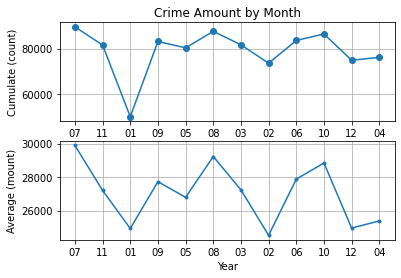

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, "o-")
plt.title("Crime Amount by Month")
plt.ylabel("Cumulate (count)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a,".-" )
plt.xlabel('Year')
plt.ylabel('Average (mount)')
plt.grid(True)
plt.savefig("YearlyCrimeAmount.png")
plt.show()

In [66]:
Yorkcrime.registerTempTable("York_Table")

In [67]:
# Create dataframe to retrieve Total and Average information by year

yearlyCrimeAmount = sqlContext.sql("select substring(Month, 0, 4) as Year, \
SUM(count) as Total, avg(count) as Average from York_Table \
group by substring(Month,0, 4)")

In [68]:
yearlyCrimeAmount

DataFrame[Year: string, Total: bigint, Average: double]

In [69]:
yearlyCrimeAmount.show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2020|313880|26156.666666666668|
|2019|311548|28322.545454545456|
|2021|323236|26936.333333333332|
+----+------+------------------+



In [70]:
#Register the yearly data in a temp table and show the contents
yearlyCrimeAmount.registerTempTable("yearlyCrime")
sqlContext.sql("select * from yearlyCrime").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2020|313880|26156.666666666668|
|2019|311548|28322.545454545456|
|2021|323236|26936.333333333332|
+----+------+------------------+



In [71]:
# Prepare variables for visualisations

yearArray = sqlContext.sql("select Total from yearlyCrime").rdd.map(lambda b:b[0]).collect()
totalArray = sqlContext.sql("select Year from yearlyCrime").rdd.map(lambda b:b[0]).collect()
averageArray = sqlContext.sql("select Average from yearlyCrime").rdd.map(lambda b:b[0]).collect()

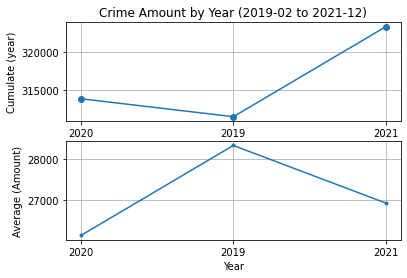

In [72]:
import matplotlib.pyplot as plt
import numpy as np

t = yearArray
y = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, "o-")
plt.title("Crime Amount by Year (2019-02 to 2021-12)")
plt.ylabel("Cumulate (year)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a,".-" )
plt.xlabel('Year')
plt.ylabel('Average (Amount)')
plt.grid(True)
plt.savefig("YearlyCrimeAmount.png")
plt.show()

In [73]:
#create a Temp Table

Yorkcrime.registerTempTable("Yorkcrime_Table")

In [74]:
monthlyCrimeAmount.registerTempTable("York_Table")
sqlContext.sql("select * from York_Table").show()

+-----+-----+------------------+
|Month|Total|           Average|
+-----+-----+------------------+
|   07|89653|29884.333333333332|
|   11|81596|27198.666666666668|
|   01|49851|           24925.5|
|   09|83168|27722.666666666668|
|   05|80362|26787.333333333332|
|   08|87671|29223.666666666668|
|   03|81696|           27232.0|
|   02|73557|           24519.0|
|   06|83612|27870.666666666668|
|   10|86515|28838.333333333332|
|   12|74849|24949.666666666668|
|   04|76134|           25378.0|
+-----+-----+------------------+



In [75]:
#create a Temporary Table Crime_Tab
PoliceYorkDF1.registerTempTable("Crime_Tab")

In [76]:
sqlContext.sql("select * from Crime_Tab").show()

+-------+--------------------+---------+---------+--------------------+--------------------+---------------------+
|  Month|         Reported_by|Longitude| Latitude|            Location|          Crime_type|Last_outcome_category|
+-------+--------------------+---------+---------+--------------------+--------------------+---------------------+
|2019-07|West Yorkshire Po...|-1.549301|53.601233|On or near Haigh ...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.647108| 53.52783|On or near Tenter...|            Burglary| Investigation com...|
|2019-07|West Yorkshire Po...|-1.882153|53.944205|On or near Parkin...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.863065|53.939035| On or near Low Mill|Violence and sexu...| Unable to prosecu...|
|2019-07|West Yorkshire Po...|-1.822203|53.922867|On or near Annand...|Anti-social behav...|                 null|
|2019-07|West Yorkshire Po...|-1.785872|53.928739|On or near Sports...|Anti-soci

In [77]:
#select distinct crime
sqlContext.sql("select distinct Crime_type from Crime_Tab").show()

+--------------------+
|          Crime_type|
+--------------------+
|       Bicycle theft|
|        Public order|
|               Drugs|
|         Other crime|
|             Robbery|
|Criminal damage a...|
|Theft from the pe...|
|         Shoplifting|
|            Burglary|
|         Other theft|
|Possession of wea...|
|Violence and sexu...|
|       Vehicle crime|
|Anti-social behav...|
+--------------------+



In [78]:
#Explore Crime Types per year/month

CrimeTypes1 = sqlContext.sql("select Crime_type, Month, \
count(*) as count from Crime_Tab group by Month, Crime_type")

In [79]:
CrimeTypes1.show()

+--------------------+-------+-----+
|          Crime_type|  Month|count|
+--------------------+-------+-----+
|       Bicycle theft|2020-07|  180|
|Criminal damage a...|2019-06| 2317|
|            Burglary|2020-06| 1180|
|Anti-social behav...|2021-10| 3044|
|Theft from the pe...|2019-09|  321|
|Violence and sexu...|2021-01| 8998|
|         Other theft|2019-03| 2115|
|             Robbery|2020-07|  209|
|Theft from the pe...|2019-08|  423|
|        Public order|2019-09| 2718|
|Anti-social behav...|2021-04| 4000|
|         Other crime|2020-12|  570|
|Criminal damage a...|2019-07| 2518|
|Possession of wea...|2021-08|  211|
|            Burglary|2020-10| 1276|
|Criminal damage a...|2020-03| 2409|
|             Robbery|2021-05|  180|
|Anti-social behav...|2020-09| 4656|
|            Burglary|2021-12| 1232|
|Criminal damage a...|2021-03| 2404|
+--------------------+-------+-----+
only showing top 20 rows



In [80]:
#Explore Crime Types per year/month

CrimeTypes = sqlContext.sql("select Crime_type, substring(Month, 6, 2) as Month, substring(Month, 0, 4) as Year, \
count(*) as count from Crime_Tab group by Month, Crime_type")

In [81]:
CrimeTypes.show()

+--------------------+-----+----+-----+
|          Crime_type|Month|Year|count|
+--------------------+-----+----+-----+
|       Bicycle theft|   07|2020|  180|
|Criminal damage a...|   06|2019| 2317|
|            Burglary|   06|2020| 1180|
|Anti-social behav...|   10|2021| 3044|
|Theft from the pe...|   09|2019|  321|
|Violence and sexu...|   01|2021| 8998|
|         Other theft|   03|2019| 2115|
|             Robbery|   07|2020|  209|
|Theft from the pe...|   08|2019|  423|
|        Public order|   09|2019| 2718|
|Anti-social behav...|   04|2021| 4000|
|         Other crime|   12|2020|  570|
|Criminal damage a...|   07|2019| 2518|
|Possession of wea...|   08|2021|  211|
|            Burglary|   10|2020| 1276|
|Criminal damage a...|   03|2020| 2409|
|             Robbery|   05|2021|  180|
|Anti-social behav...|   09|2020| 4656|
|            Burglary|   12|2021| 1232|
|Criminal damage a...|   03|2021| 2404|
+--------------------+-----+----+-----+
only showing top 20 rows



In [82]:
import pixiedust

Pixiedust database opened successfully


In [83]:
# Explore Crime Types per Year/Month

CrimeTypesGeo = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Latitude, Longitude, \
count(*) as Count from Crime_Tab group by Month, \
Crime_type, Latitude, Longitude")


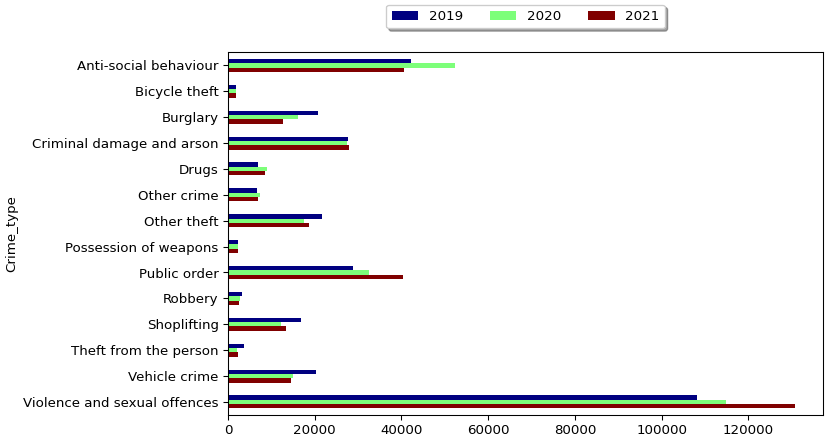

In [84]:
display(CrimeTypes)


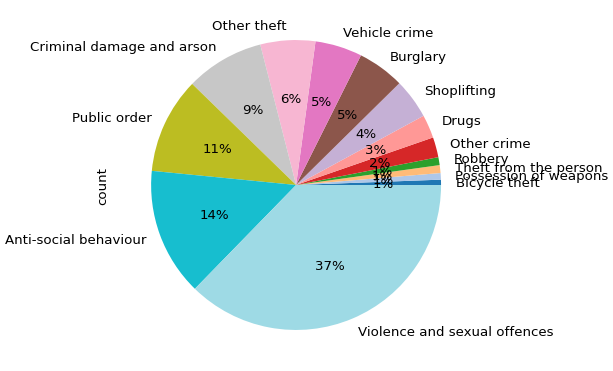

In [85]:
display(CrimeTypes)


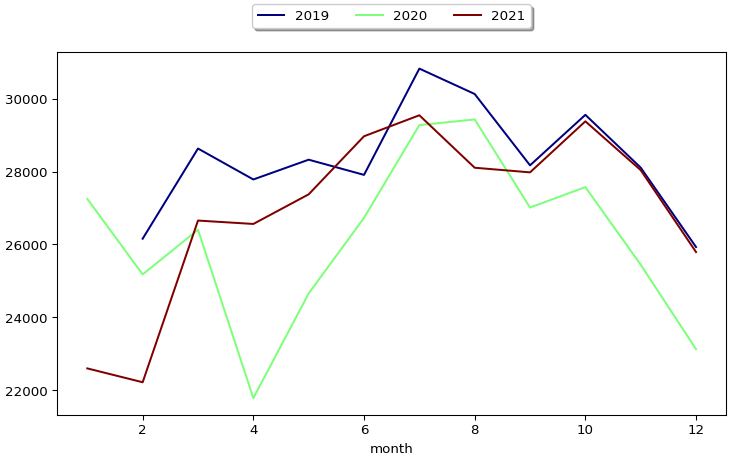

In [86]:
display(PoliceYorkDF4)

In [87]:
display(CrimeTypesGeo)


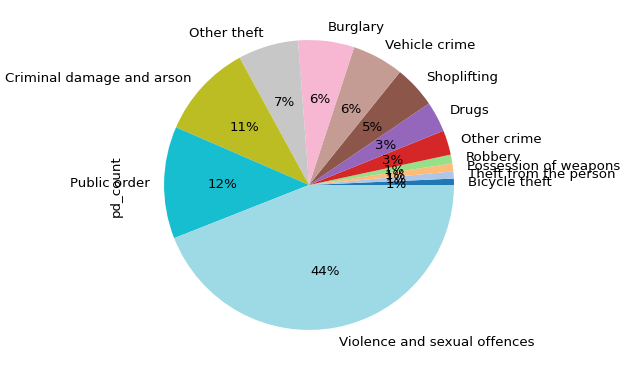

In [88]:
#piechart for 2020 crimes
display(DF2020_crime)

In [ ]:
display(DF2020_crime)

In [ ]:
display(DF2021_crime)


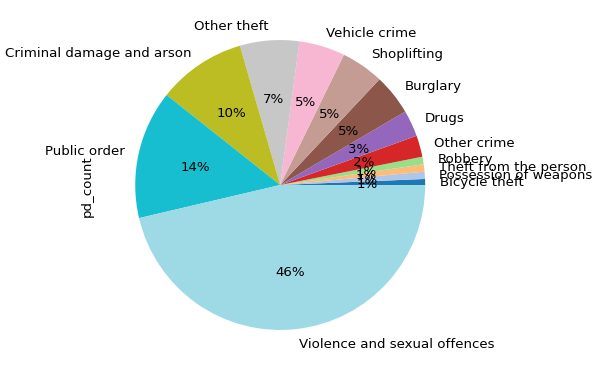

In [ ]:
display(DF2021_crime)

In [92]:
#   Tokens for usng map on pixiedust
#   pk.eyJ1IjoiYmx1a2llIiwiYSI6ImNsMHcwYm91ejE3cHQzY241MzkxODY3emYifQ.FqXQ_1iFgdHU8vMkIxOQJw